# Segmentación de amastigotes T.Cruzi

### Se importan las librerías necesarias

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
import cv2
import glob
import tifffile as tiff
import imagecodecs

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import staintools
import re

### Ajustes iniciales:
#### Tamaño de las imágenes
#### Directorios
#### Matrices donde guardaremos las imágenes
#### Organizamos las imágenes en orden natural

In [2]:
# Semilla random para verificar los resultados
seed = 42
np.random.seed = seed

# Dimensiones de las imágenes
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# Funciones para organizar las listas de manera natural
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

# Directorios raíz
XTRAIN_PATH = sorted(glob.glob('/almac/alfonso_tv/X_train/*.tif'), key=natural_keys)
YTRAIN_PATH = sorted(glob.glob('/almac/alfonso_tv/Y_train/*.tif'), key=natural_keys)
#TEST_PATH = sorted(glob.glob('/almac/alfonso_tv/X_train/*.tif'), key=natural_keys)

# Número de imágenes con las que se trabajarán (Opcional)
#XTRAIN_PATH = XTRAIN_PATH[500:1000]
#YTRAIN_PATH = YTRAIN_PATH[500:1000]
#TEST_PATH = TEST_PATH[:3500]
 
# Matrices donde se guardarán las imágenes (Opcional)
#X_train = np.zeros((len(XTRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
#Y_train = np.zeros((len(YTRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
#X_test = np.zeros((len(TEST_PATH), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)

## Cargamos las imágenes

In [3]:
x_train = np.zeros((len(XTRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
for n,item in tqdm(enumerate(XTRAIN_PATH), total=len(XTRAIN_PATH)):
    img = tiff.imread(item)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n]=img
print(len(x_train))

100%|██████████| 500/500 [06:29<00:00,  1.28it/s]

500


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f7d5a6ebf50>)

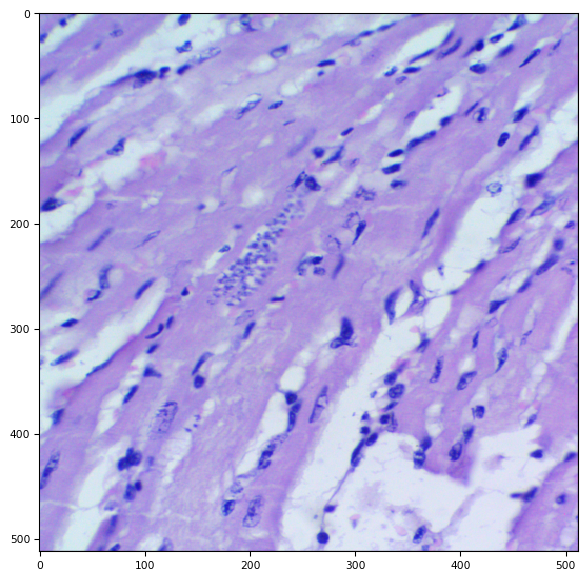

In [30]:
tiff.imshow(x_train[2999])

## Cargamos las máscaras

In [4]:
y_train = np.zeros((len(YTRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
for n,item in tqdm(enumerate(YTRAIN_PATH), total=len(YTRAIN_PATH)):
    img = cv2.imread(item)[:,:,:1]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_train[n]=(img)
print(len(y_train))

100%|██████████| 500/500 [01:18<00:00,  6.38it/s]

500


(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f7d5a510e50>)

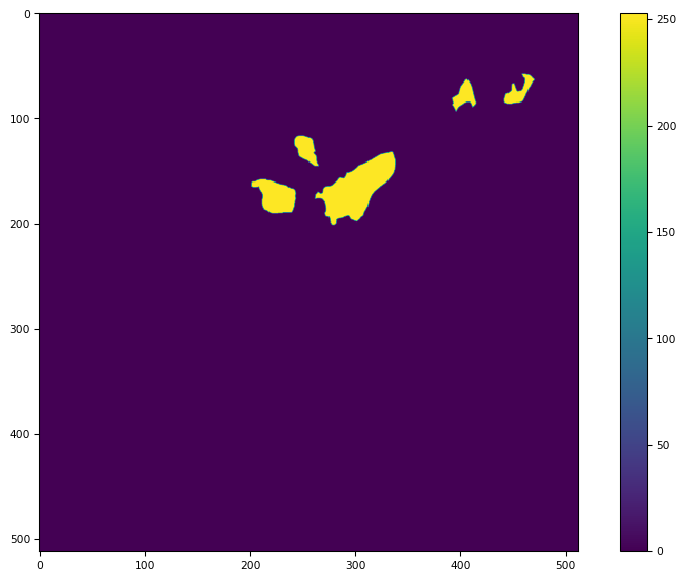

In [50]:
tiff.imshow(y_train[0])

## Detección de casos positivos

In [5]:
# Creamos un diccionario con los nombres e imágenes cargadas
nombre_e_imagen_y = dict(zip(YTRAIN_PATH, y_train))
nombre_e_imagen_x = dict(zip(XTRAIN_PATH, x_train)) 

In [6]:
print(nombre_e_imagen_y[YTRAIN_PATH[0]])

[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


In [7]:
P_num = 0 # Numero de casos positivos
Y_Positives = [] # Lista de casos positivos
N_num = 0 # Numero de casos negativos
Y_Negatives = [] # Lista de casos negativos

for name in tqdm(nombre_e_imagen_y.keys()):
    if True in nombre_e_imagen_y[name]: # Verifica si el promedio de los valores de la máscara == 0 para verificar su clase
        Y_Positives.append(name)
        P_num += 1
    else:
        Y_Negatives.append(name)
        N_num += 1

print("El número de casos positivos es: ", P_num)
print("El número de casos negativos es:  ", N_num)

100%|██████████| 500/500 [00:00<00:00, 1265.60it/s]

El número de casos positivos es:  232
El número de casos negativos es:   268


In [8]:
print(Y_Negatives[0:4])

['/almac/alfonso_tv/Y_train/Original-733.tif', '/almac/alfonso_tv/Y_train/Original-734.tif', '/almac/alfonso_tv/Y_train/Original-735.tif', '/almac/alfonso_tv/Y_train/Original-736.tif']


## Cambiar ruta de Y_train a X_train

In [9]:
X_Negatives = []
for item in Y_Negatives:
    item = item.split('/')
    #print(item)
    item[3] = 'X_train'
    #print(item)
    item = '/'.join(item)
    #print(item)
    X_Negatives.append(item)
print(X_Negatives[0:4])

['/almac/alfonso_tv/X_train/Original-733.tif', '/almac/alfonso_tv/X_train/Original-734.tif', '/almac/alfonso_tv/X_train/Original-735.tif', '/almac/alfonso_tv/X_train/Original-736.tif']


In [10]:
# Se eliminan los casos negativos presentes en el diccionario de xtrain
for negative in X_Negatives:
    if negative in nombre_e_imagen_x:
        nombre_e_imagen_x.pop(negative)
        
for negative in Y_Negatives:
    if negative in nombre_e_imagen_y:
        nombre_e_imagen_y.pop(negative)

In [11]:
# Se verifica que no haya quedado alguno
for negative in X_Negatives:
    if negative in nombre_e_imagen_x:
        print(True)
    if negative == X_Negatives[-1]:
        print('Ya no hay casos negativos en xtrain')

for negative in Y_Negatives:
    if negative in nombre_e_imagen_y:
        print(True)
    if negative == Y_Negatives[-1]:
        print('Ya no hay casos negativos en ytrain')

Ya no hay casos negativos en xtrain
Ya no hay casos negativos en ytrain


In [12]:
# Variables limpias de casos negativos, deben coincidir X y Y
X = list(nombre_e_imagen_x.values())
print(len(X))
Y = list(nombre_e_imagen_y.values())
print(len(Y))

232
232


In [27]:
print(X[0].shape)

(512, 512, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fca0eafc510>)

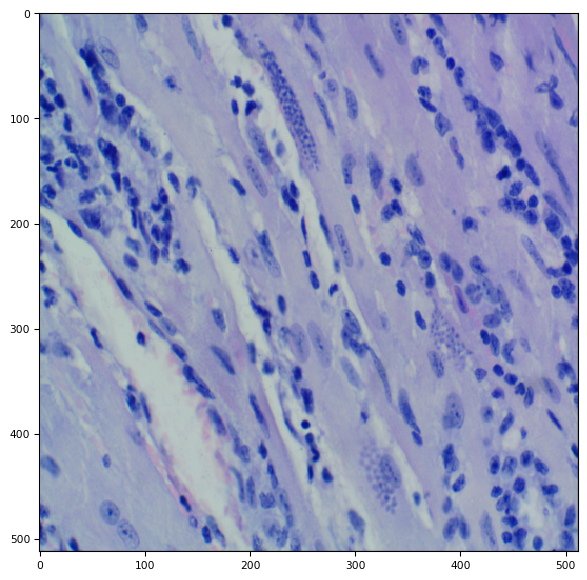

In [13]:
tiff.imshow(X[0])

/almac/alfonso_tv/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/tifffile/tifffile.py:13122: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ) for axis in range(dims)


(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f01913a4f90>)

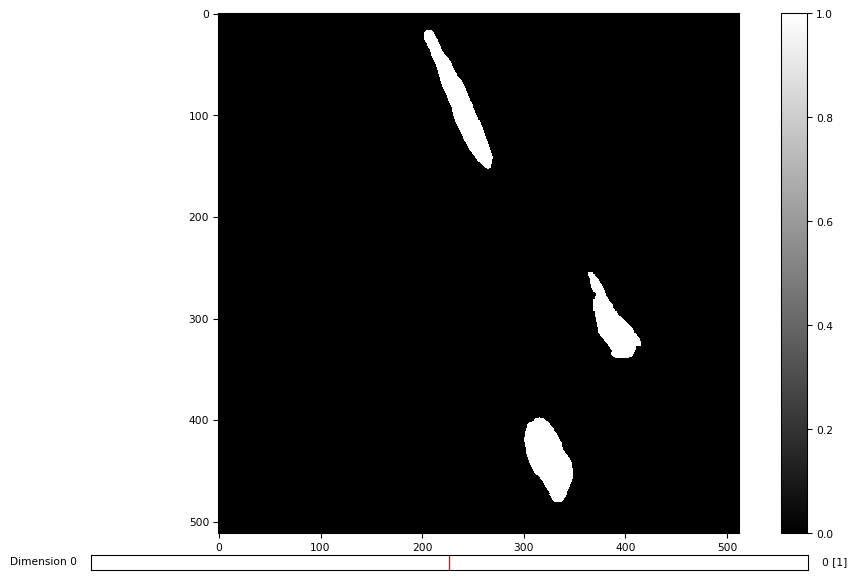

In [27]:
tiff.imshow(Y[0])

## U-Net

In [14]:
# Design our model architecture here
def keras_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    # U-NET Model
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalización de los pixeles

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    unet = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    unet.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.MeanIoU(num_classes=2)]) # MeanIoU
    unet.summary() # Table to verify model components
    
    return unet

In [15]:
unet = keras_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
print(unet)

## Cross-validation

In [17]:
from sklearn.model_selection import KFold

In [18]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 10, monitor ='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs_final'),
        tf.keras.callbacks.ModelCheckpoint('Model_for_Chagas.h5', verbose=1, save_best_only='True')]

In [19]:
def get_score(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train, batch_size=1, epochs=50,validation_split=0.1, callbacks=callbacks)
    return model.evaluate(X_test, Y_test)

### Entrenamiento

In [20]:
scores_unet = []

kf = KFold(5)
kf.split(X,Y)
#print(len(X[0]))
for train, test in kf.split(X, Y):
    X_train, X_test, Y_train, Y_test = np.array(X)[train], np.array(X)[test], np.array(Y)[train], np.array(Y)[test]
    scores_unet.append(get_score(unet,X_train,X_test,Y_train,Y_test))

Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9823 - mean_io_u: 0.4913
Epoch 00001: val_loss improved from inf to 0.07583, saving model to Model_for_Chagas.h5
166/166 [==============================] - 179s 1s/step - loss: 0.0903 - binary_accuracy: 0.9823 - mean_io_u: 0.4913 - val_loss: 0.0758 - val_binary_accuracy: 0.9832 - val_mean_io_u: 0.4916
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 0.0805 - binary_accuracy: 0.9827 - mean_io_u: 0.4913
Epoch 00002: val_loss improved from 0.07583 to 0.07479, saving model to Model_for_Chagas.h5
166/166 [==============================] - 177s 1s/step - loss: 0.0805 - binary_accuracy: 0.9827 - mean_io_u: 0.4913 - val_loss: 0.0748 - val_binary_accuracy: 0.9832 - val_mean_io_u: 0.4916
Epoch 3/50
166/166 [==============================] - ETA: 0s - loss: 0.0764 - binary_accuracy: 0.9827 - mean_io_u: 0.4913
Epoch 00003: val_loss improved from 0.07479 to 0.07149, saving model to

## Resultados y predicciones

In [22]:
for scores in scores_unet:
    print('Val loss: {}'.format(scores[0]))
    print('Binary Accuracy: {}'.format(scores[1]))
    print('MeanIoU: {}'.format(scores[2]))

Val loss: 0.03791147097945213
Binary Accuracy: 0.9882045388221741
MeanIoU: 0.49105745553970337
Val loss: 0.022034404799342155
Binary Accuracy: 0.9932056069374084
MeanIoU: 0.49085456132888794
Val loss: 0.021569693461060524
Binary Accuracy: 0.9937852621078491
MeanIoU: 0.4912028908729553
Val loss: 0.024832209572196007
Binary Accuracy: 0.9931448101997375
MeanIoU: 0.4914458692073822
Val loss: 0.028123503550887108
Binary Accuracy: 0.9924765825271606
MeanIoU: 0.4938408434391022


In [23]:
Val_loss = 0
Binary_Acc = 0
MeanIoU = 0
for scores in scores_unet:
    if scores[0] > Val_loss:
        Val_loss = scores[0]
    if scores[1] > Binary_Acc:
        Binary_Acc = scores[1]
    if scores[2] > MeanIoU:
        MeanIoU = scores[2]
print('Los mejores resultados fueron:\nVal loss de ',Val_loss,'\nBinary Accuracy de ',Binary_Acc,'\nMeanIoU de ',MeanIoU)

Los mejores resultados fueron:
Val loss de  0.03791147097945213 
Binary Accuracy de  0.9937852621078491 
MeanIoU de  0.4938408434391022


In [24]:
pVal = 0
pBin = 0
pMean = 0
for scores in scores_unet:
    pVal += scores[0]
    pBin += scores[1]
    pMean += scores[2]
pVal = pVal/5
pBin = pBin/5
pMean = pMean/5
print('El promedio de cada uno fue:\nVal loss de ',pVal,'\nBinary Accuracy de ',pBin,'\nMeanIoU de ',pMean)

El promedio de cada uno fue:
Val loss de  0.026894256472587585 
Binary Accuracy de  0.992163360118866 
MeanIoU de  0.4916803240776062


In [37]:
preds_train = unet.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val = unet.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 3ms/step


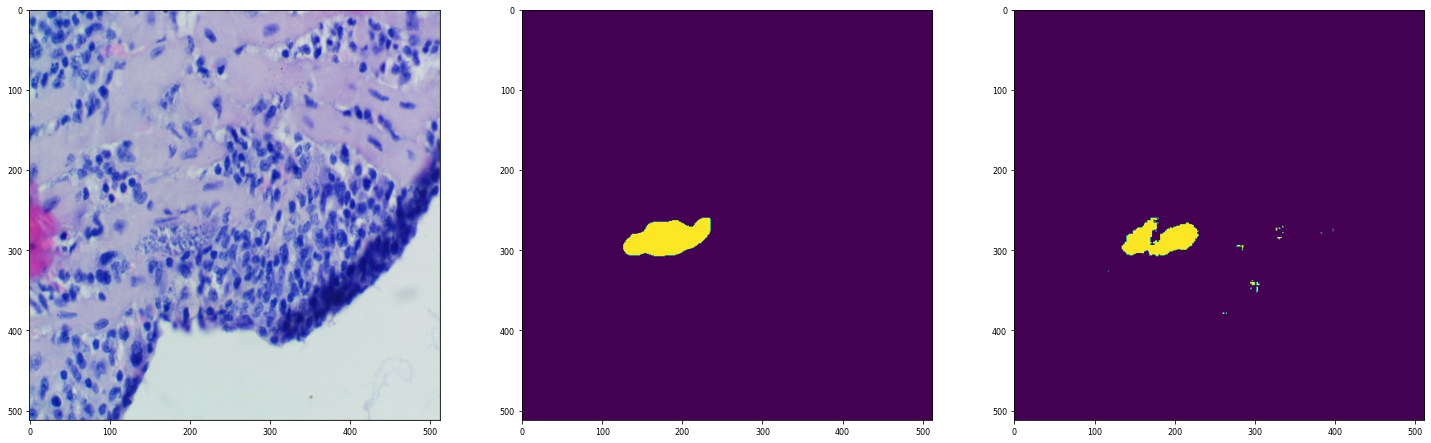

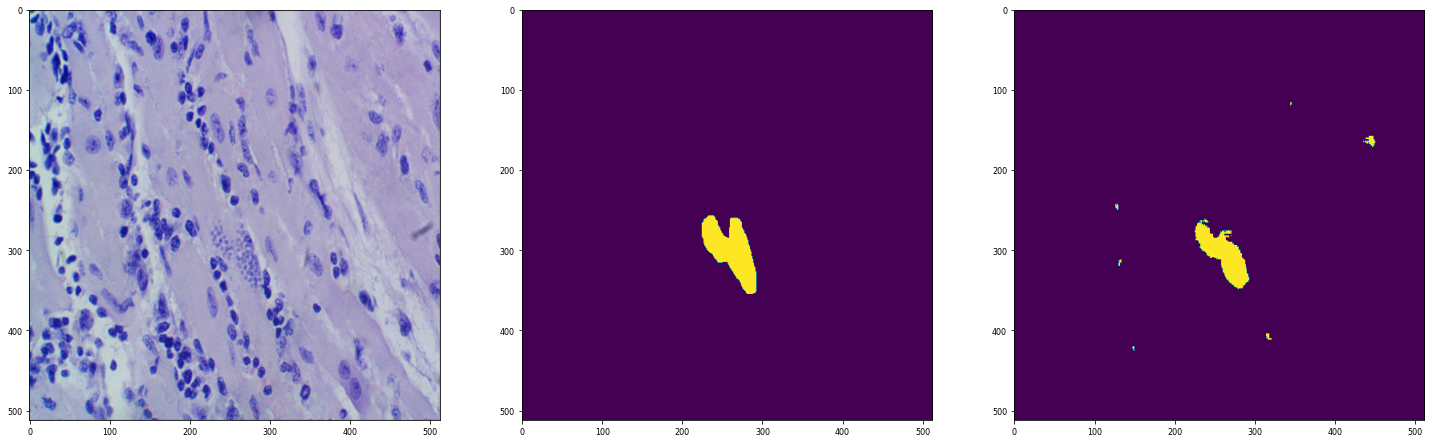

In [46]:
# Perform a sanity check on some random training samples
fig=plt.figure(figsize=(25,15))
ix = 2
fig.add_subplot(1,3,1)
plt.imshow(X_train[ix])
fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
fig=plt.figure(figsize=(25,15))
ix2 = 3
fig.add_subplot(1,3,1)
plt.imshow(X_train[int(X_train.shape[0]*0.9):][ix2])
fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix2]))
fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(preds_val_t[ix2]))
plt.show()

## Métricas.py

Cyan - TP
Magenta - FP
Yellow - FN
Black - TN


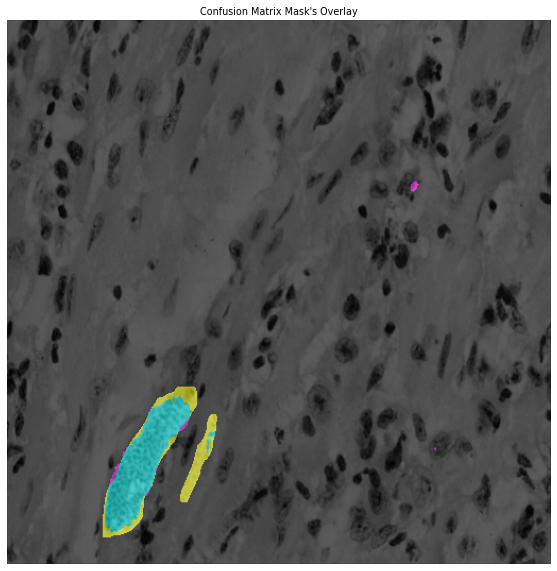

In [47]:
import Metricas as m
n = 3
validation_mask = m.get_confusion_matrix_overlaid_mask(X_train[n], Y_train[n], preds_train_t[n])

plt.figure(figsize=(10,10))
plt.imshow(validation_mask)
plt.axis('off')
plt.title("Confusion Matrix Mask's Overlay")
plt.show()

In [60]:
score_train = unet.evaluate(X_train,Y_train, steps=10)
print('Acctrain =', score_train[1])

10/10 [==============================] - 26s 3s/step - loss: 0.0168 - binary_accuracy: 0.9945 - mean_io_u: 0.4915
Acctrain = 0.994548499584198


In [59]:
print(Y_train.shape)
print(preds_train.shape)

(186, 512, 512, 1)
(167, 512, 512, 1)


In [62]:
print('Metricas entrenamiento completo')
m.metricas(Y_train, preds_train_t)

Metricas entrenamiento completo
Matriz de confusión:
[[  607993   193634]
 [   46678 42929743]]
Recall = 0.92870
Precision = 0.75845
DICE/F1 = 0.83498
JAC/IoU = 0.71672
Acurracy = 0.99451
Specificity = 0.99551


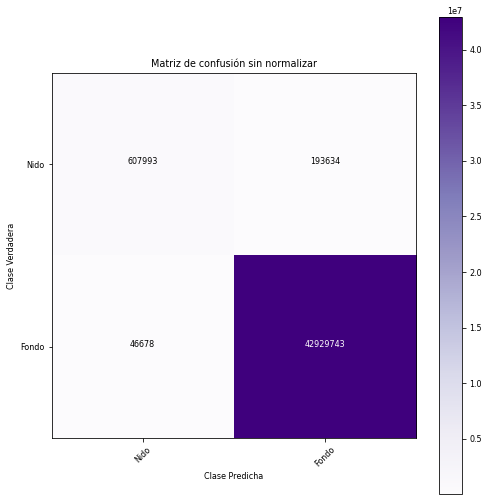

In [64]:
objects = ['Nido','Fondo']
matrix = m.matriz_confusion(Y_train,preds_train_t)
m.plot_confusion_matrix(matrix, classes=objects, normalize=False)

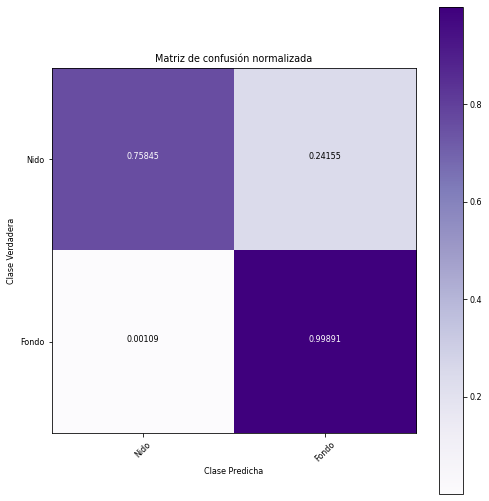

In [65]:
m.plot_confusion_matrix(matrix, classes=objects, normalize=True)

In [67]:
df = m.conteo(Y_train, preds_train_t)
df.to_csv('Res_final.csv')

In [68]:
df

,Nidos,Nidos predichos,Diferencia_N,Área_total,Área_predicha,Diferencia_A
Imagen,,,,,,
0,3.0,5.0,2.0,6767.0,3786.0,-2981.0
1,1.0,8.0,7.0,6998.0,5114.0,-1884.0
2,1.0,21.0,20.0,3564.0,2765.0,-799.0
3,2.0,9.0,7.0,5987.0,4403.0,-1584.0
4,1.0,27.0,26.0,2325.0,1645.0,-680.0
...,...,...,...,...,...,...
162,1.0,3.0,2.0,3693.0,2215.0,-1478.0
163,1.0,8.0,7.0,5952.0,4748.0,-1204.0
164,1.0,7.0,6.0,4657.0,3489.0,-1168.0


### Tensorboard

In [2]:
#%load_ext tensorboard

In [3]:
#tensorboard --logdir=/ --host localhost --port 8501

In [ ]:
import matplotlib.pyplot as plt

epoch_max = np.argmax(results.history['val_loss'])
plt.figure(num=None, figsize=(4, 3))
plt.plot(results.history['loss'], label='training')
plt.plot(results.history['val_loss'], label='validation')
plt.legend(loc='lower right')
plt.plot(epoch_max, results.history['val_loss'][epoch_max],'*')
plt.title('Loss')
plt.show()